# Install AI2-THOR

ProcTHOR houses are loaded into `ai2thor` and distributed with the `prior` package. We'll also install a helper package, called `ai2thor_colab`, which allows us to run AI2-THOR in Google Colab.

Let's install each of these packages below:

In [ ]:
# Here, we'll install and use a pre-release of AI2-THOR.
!pip install --extra-index-url https://ai2thor-pypi.allenai.org ai2thor==0+391b3fae4d4cc026f1522e5acf60953560235971 &> /dev/null
!pip install ai2thor-colab prior --upgrade &> /dev/null
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download ProcTHOR-10k

Now, let's use the `prior` package to easily download the `procthor-10k` dataset:

In [ ]:
import prior

dataset = prior.load_dataset("procthor-10k")

Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 3610.82it/s]


In [ ]:
from ai2thor.controller import Controller
import ai2thor_colab
from ai2thor_colab import plot_frames

In [ ]:
ai2thor_colab.start_xserver()

Select the houses that includes these 10 object types

In [ ]:
object_list = ['Book', 'Pillow', 'SprayBottle', 'Mug', 'Apple', 'Pen', 'Bowl', 'RemoteControl', 'AlarmClock', 'Laptop']

In [ ]:
'''
Only have your house id's
'''
house_id_list = [492, 497]

In [ ]:

train_set = dataset['train']
object_removal_map = {}
selected_house_objects = {house_id: {obj_type:{} for obj_type in object_list} for house_id in house_id_list}
# Sample object ids for each house
for house_id in house_id_list:
  object_removal_map[house_id] = []
  house_obj_candidates = {obj_type: [] for obj_type in object_list}
  house = train_set[house_id]
  objs = house['objects']
  for asset in objs:
    obj_type = asset['id'].split('|')[0]
    if obj_type in object_list:
      house_obj_candidates[obj_type].append({'position': asset['position'], 'objectId': asset['id']})
    if 'children' in asset.keys():
      for child_asset in asset['children']:
        obj_type = child_asset['id'].split('|')[0]
        if obj_type in object_list:
          house_obj_candidates[obj_type].append({'position':child_asset['position'], 'objectId': child_asset['id']})
  for object_type in object_list:
    selected_house_objects[house_id][object_type] = house_obj_candidates[object_type][0] 
    if len(house_obj_candidates[object_type]) > 1:
      for remove_object in range(1,len(house_obj_candidates[object_type])):
        object_removal_map[house_id].append(house_obj_candidates[object_type][remove_object]['objectId'])

# Annotation methods

Connect Google Drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
output_dir_root = '/content/drive/My Drive/semantic_mapping_project/'
output_dir_name = 'nlp_project/'
image_dir_name = output_dir_name + 'frames/'

Mounted at /content/drive


In [ ]:
import json
from PIL import Image
import cv2
import numpy as np
import time
import copy
from google.colab.patches import cv2_imshow

In [ ]:
input_shorthand_mapping = {
    'w': 'MoveAhead',
    'a': 'MoveLeft',
    'd': 'MoveRight',
    's': 'MoveBack',
    'j': 'RotateLeft',
    'l': 'RotateRight',
    'i': 'LookUp',
    'k': 'LookDown',
    'pick' : 'PickUpObject',
    'open': 'OpenObject',
    'end' : 'end'
}
bool_shorthand = {
    'y': True,
    'n': False
}

In [ ]:
def get_objects(current_metadata, action_type):
  object_id_list = []
  for objects in current_metadata : 
    if objects['visible'] == True and objects[action_type] == True:
      object_id_list.append(objects['objectId'])
  return object_id_list

In [ ]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=8):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav', 'wb') as f:
    f.write(b)
  return 'audio.wav'  # or webm ?

In [ ]:
import os

In [ ]:
from numpy.lib.npyio import save
import shutil
def annotate_instance(
  house_id,
  target_object_type,
  save_run = True
):
  house = dataset["train"][house_id]
  controller=Controller(
      scene=house,
      visibilityDistance=2.0,
      gridSize = 0.50
  )

  '''
  Keeping 1 instance of an object type per scene
  '''
  objectIdsToBeRemoved = object_removal_map[house_id]
  for ids in objectIdsToBeRemoved:
    controller.step(action="RemoveFromScene",objectId=ids) 
  print('Scene Pre-Processing done!')

  target_object_location = selected_house_objects[house_id][target_object_type]['position']
  target_object_id = selected_house_objects[house_id][target_object_type]['objectId']
  
  actions = []
  frames_dir = image_dir_name + f"house_{house_id}/{target_object_type}/"
  if not os.path.exists(output_dir_root + frames_dir):
    os.makedirs(output_dir_root + frames_dir)
  json_path = output_dir_root + output_dir_name + f"house_{house_id}_{target_object_type}.json"
  all_pickup = []
  all_open = []
  output_dict = {
      "house_id": house_id,
      "intentions": [],
      "target_object_type": target_object_type,
      "frames_dir": frames_dir
  }
  input_action = None
  t = 0
  while True:
    
    action_dict = {
      "action": None,
      "pickedObject": None,
      "openedObject": None
    }

    if input_action == "end":
      break
    
    curr_event = controller.last_event
    frame_path = output_dir_root + frames_dir + f'frame_{t}.jpg'
    
    saved_image = (Image.fromarray(curr_event.frame))
    cv2_imshow(curr_event.frame)
    cv2.waitKey(0)
    time.sleep(1)


    print(f"Target object location: {target_object_location}")
    print(f"Current agent information: {controller.last_event.metadata['agent']['position']}")

    action_intention_iter = []
    input_action = input("Type in a valid action :")
    try:
      input_action = input_shorthand_mapping[input_action]
    except:
      print('Wrong input given, try again!')
      continue
    
    action_dict["action"] = input_action
    visible_pickupable_objects = get_objects(curr_event.metadata["objects"],'pickupable')
    visible_openable_objects = get_objects(curr_event.metadata["objects"],'openable')
    
    picked_object = None
    opened_object = None
    if input_action != 'end':
      
      if input_action == 'PickUpObject':
        if len(visible_pickupable_objects) == 0:
          print('No visible objects can be picked up')
          continue
        else :
          print('Objects that can be picked up are : ', visible_pickupable_objects)
          input_object = input("Type in the object to be picked up")
          if input_object not in visible_pickupable_objects:
            print('Wrong input given')
            continue
          else:
            controller.step(action = 'PickupObject',objectId = input_object)
            picked_object = input_object
      elif input_action == 'OpenObject':
        if len(visible_openable_objects) == 0:
          print('No visible objects can be opened')
          continue
        else :
          print('Objects that can be opened are : ', visible_openable_objects)
          input_object = input("Type in the object you want to open")
          if input_object not in visible_openable_objects:
            print('Wrong input given')
            continue
          else:
            controller.step(action = 'OpenObject',objectId = input_object, openness=1)
            opened_object = input_object
      else:
        controller.step(action=input_action)

    if save_run:
        saved_image.save(frame_path)
    all_pickup.append(visible_pickupable_objects)
    all_open.append(visible_openable_objects)

    action_dict["pickedObject"] = picked_object
    action_dict["openedObject"] =  opened_object
    actions.append(action_dict)

    t += 1

  output_dict["actions"] = actions
  output_dict["pickupable_objects"] = all_pickup
  output_dict["openable_objects"] = all_open

  if save_run:
    with open(f"{json_path}","w") as f:
      json.dump(output_dict, f, indent = 4)
  return

thor-Linux64-391b3fae4d4cc026f1522e5acf60953560235971.zip: [ 100%  24.8 MiB/s]  of 780.MB


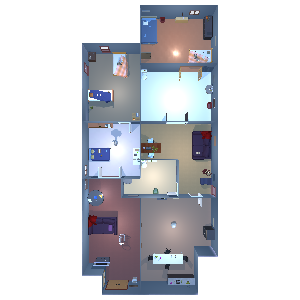

In [ ]:
import copy

def get_top_down_frame(house_id):
    # Setup the top-down camera
    house = dataset["train"][house_id]
    controller=Controller(
        scene=house,
        visibilityDistance=2.0,
        gridSize = 0.50
    )
    event = controller.step(action="GetMapViewCameraProperties", raise_for_failure=True)
    pose = copy.deepcopy(event.metadata["actionReturn"])

    bounds = event.metadata["sceneBounds"]["size"]
    max_bound = max(bounds["x"], bounds["z"])

    pose["fieldOfView"] = 50
    pose["position"]["y"] += 1.1 * max_bound
    pose["orthographic"] = False
    pose["farClippingPlane"] = 50
    del pose["orthographicSize"]

    # add the camera to the scene
    event = controller.step(
        action="AddThirdPartyCamera",
        **pose,
        skyboxColor="white",
        raise_for_failure=True,
    )
    top_down_frame = event.third_party_camera_frames[-1]
    return Image.fromarray(top_down_frame)


get_top_down_frame(492)

Scene Pre-Processing done!


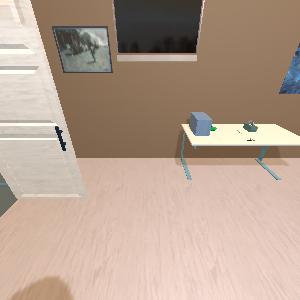

Target object location: {'x': 6.704521656036377, 'y': 0.6433757543563843, 'z': 1.999267339706421}
Current agent information: {'x': 2.5, 'y': 0.9009997844696045, 'z': 13.0}
Type in a valid action :w


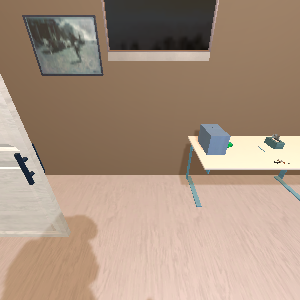

Target object location: {'x': 6.704521656036377, 'y': 0.6433757543563843, 'z': 1.999267339706421}
Current agent information: {'x': 3.0, 'y': 0.9009997844696045, 'z': 13.0}
Type in a valid action :d


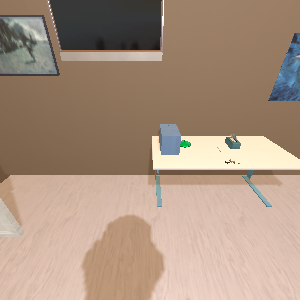

Target object location: {'x': 6.704521656036377, 'y': 0.6433757543563843, 'z': 1.999267339706421}
Current agent information: {'x': 3.0, 'y': 0.9009997844696045, 'z': 12.5}
Type in a valid action :d


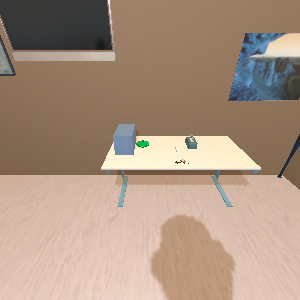

Target object location: {'x': 6.704521656036377, 'y': 0.6433757543563843, 'z': 1.999267339706421}
Current agent information: {'x': 3.0, 'y': 0.9009997844696045, 'z': 12.0}
Type in a valid action :l


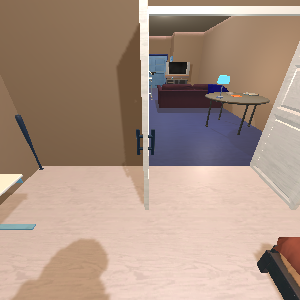

Target object location: {'x': 6.704521656036377, 'y': 0.6433757543563843, 'z': 1.999267339706421}
Current agent information: {'x': 3.0, 'y': 0.9009997844696045, 'z': 12.0}
Type in a valid action :l


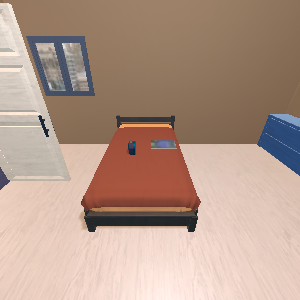

Target object location: {'x': 6.704521656036377, 'y': 0.6433757543563843, 'z': 1.999267339706421}
Current agent information: {'x': 3.0, 'y': 0.9009997844696045, 'z': 12.0}
Type in a valid action :l


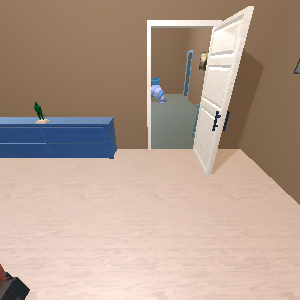

Target object location: {'x': 6.704521656036377, 'y': 0.6433757543563843, 'z': 1.999267339706421}
Current agent information: {'x': 3.0, 'y': 0.9009997844696045, 'z': 12.0}
Type in a valid action :end


In [ ]:
annotate_instance(house_id = 492, target_object_type = "Pen", save_run = True)